In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score as accuracy


colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [234]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Binary Classification/data_ecommerce_customer_churn.csv')
df.head(3)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0


In [235]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [236]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    plt.figure(figsize = (10,10))
    for visualization in range(2):
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()
        
      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[0])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show() 

In [237]:
class Data_Preprocessing:
  def __init__(self,df,target_feature = None):
    self.df = df
    self.target_feature = target_feature

  def _feature_target_split(self):
    if self.target_feature != None:
      X = self.df[[feature for feature in self.df.columns if feature != self.target_feature]]
      y = self.df[self.target_feature]
      return X,y

    else:
      X = self.df
      return X

  def _one_hot(self,X):
    ohe = OneHotEncoder(handle_unknown = 'ignore',sparse_output = False).set_output(transform = 'pandas')
    
    return ohe.fit_transform(X)

    return X

  def _normalize(self,X):
    X = normalize(X)
    return X
    

  def transform(self):
    if self.target_feature != None:
      numerical_features = eda.numerical_features()
      numerical_features = list(numerical_features)
      numerical_features.remove(self.target_feature)
      numerical_features = np.array(numerical_features)

      categorical_features = eda.categorical_features()

      X,y = self._feature_target_split()
      X,y = X.fillna(value = 0),y.fillna(value = 'Nan')

      X_num = self._normalize(X[numerical_features].astype(np.float64))
      X_cat = self._one_hot(X[categorical_features].astype('str'))

      X_num = pd.DataFrame(X_num,columns = numerical_features)
      X_cat = pd.DataFrame(X_cat)

      X = pd.concat([X_num,X_cat],axis = 1)

      return X,y

    else:
      numerical_features = [column for column in self.df.columns if self.df[column].dtype != 'O']
      categorical_features = eda.categorical_features()

      X = self._feature_target_split()
      X = X.fillna(value = 0)

      X_num = self._normalize(X[numerical_features].astype(np.float64))
      X_cat = self._one_hot(X[categorical_features].astype('str'))

      X_num = pd.DataFrame(X_num,columns = numerical_features)
      X_cat = pd.DataFrame(X_cat)

      X = pd.concat([X_num,X_cat],axis = 1)

      return X

In [238]:
class VotingClassifier:
  def __init__(self,models,vote = 'Hard'):
    self.models = models
    self.vote = vote

    self._fit_models = []

  def _bootstrap(self,X):
    n_samples = X.shape[0]
    random_idxs = np.random.choice(n_samples,n_samples,replace = True)

    return X[random_idxs]

  def _most_common(self,y):
    from collections import Counter

    counter = Counter(y)
    most_common_value = counter.most_common(1)[0][0]

    return most_common_value

  def fit(self,X,y):
    import joblib
    for model_idx,model in enumerate(self.models):
        model.fit(X,y)
        self._fit_models.append(joblib.dump(model,f'voting_model_{model_idx}'))


  def predict(self,X,treshold = 0.5):
    import joblib
    if self.vote == 'Hard':
      votes = []
      for model_name in self._fit_models:
        model = joblib.load(model_name[0])

        vote = model.predict(X)
        votes.append(vote)

      votes = np.array(votes)
      votes = np.array([votes[:,sample_idx] for sample_idx in range(votes.shape[1])])

      labels = [self._most_common(vote) for vote in votes]

      return np.array(labels)

    elif self.vote == 'Soft':
      probs = []
      for model_name in self._fit_models:
        model = joblib.load(model_name[0])

        prob = model.predict_proba(X)[:,1]
        probs.append(prob)

      probs = np.array(probs)
      probs = np.array([probs[:,sample_idx] for sample_idx in range(probs.shape[1])])

      labels = [1 if np.mean(prob) > treshold else 0 for prob in probs]

      return np.array(labels)

In [239]:
class Bagging_Classifier:
  def __init__(self,estimator,n_estimators):
    self.estimator = estimator
    self.n_estimators = n_estimators

    self._fit_estimators = []

  def _bootstrap(self,X,y):    
    n_samples = X.shape[0]
    random_idxs = np.random.choice(n_samples,n_samples,replace = True)

    return X.iloc[random_idxs],y.iloc[random_idxs]

  def _most_common(self,y):
    from collections import Counter

    counter = Counter(y)
    most_common_value = counter.most_common(1)[0][0]

    return most_common_value

  def fit(self,X,y):
    import joblib
    for estimator_idx in range(self.n_estimators):
      X,y = self._bootstrap(X,y)

      fit_estimator = self.estimator.fit(X,y)
      self._fit_estimators.append(joblib.dump(fit_estimator,f'bagging_model_{estimator_idx}'))


  def predict(self,X):
    import joblib
    votes = []
    for estimator_name in self._fit_estimators:
      estimator = joblib.load(estimator_name[0])
      vote = estimator.predict(X)
      votes.append(vote)

    votes = np.array(votes)
    votes = np.array([votes[:,sample_idx] for sample_idx in range(votes.shape[1])])

    labels = [self._most_common(vote) for vote in votes]

    return np.array(labels)

In [240]:
class Train_model:
  def __init__(self,model,metric,X_train,y_train,X_test = None,y_test = None,params = None,grid_search = None):
    self.model = model
    self.metric = metric

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.params = params

    self.grid_search = grid_search

  def fit(self):
    if self.grid_search == None or self.params == None:
      print(f'Model: {self.model}')
      print(f'X for train n_samples: {self.X_train.shape[0]}')
      print(f'X for train n_features: {self.X_train.shape[1]}\n')

      self._fit_model = self.model.fit(self.X_train,self.y_train)
      y_pred = self._fit_model.predict(self.X_train)

      metric_score = self.metric(self.y_train,y_pred)
      print(f'{self.metric} on Train Data: {metric_score}')

      return self._fit_model


    else:
      print(f'Model: {self.model}')
      print(f'X for train n_samples: {self.X_train.shape[0]}')
      print(f'X for train n_features: {self.X_train.shape[1]}\n')
      
      grid_search = self.grid_search(self.model,self.params)
      
      self._fit_model = grid_search.fit(self.X_train,self.y_train)
      y_pred = self._fit_model.predict(self.X_train)

      metric_score = self.metric(self.y_train,y_pred)
      print(f'{self.metric} on Train Data: {metric_score}')

      return self._fit_model

  def eval(self):
    y_pred = self._fit_model.predict(self.X_test)
    metric_score = self.metric(self.y_test,y_pred)

    print(f'{self.metric} on Test Data: {metric_score}\n\n')

    return metric_score

In [241]:
class Optimal_model:
  def __init__(self,models,metric,X_train,y_train,X_test,y_test,params = None):
    self.models = models
    self.metric = metric

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.params = params

    self.test_metric_scores = []

  def fit(self):
    for model in self.models:
      print(f'\nModel: {model}')
      Trainer = Train_model(model,self.metric,self.X_train,self.y_train,self.X_test,self.y_test,self.params)
      print(f'Trainer: {Trainer}')

      Trainer.fit()
      metric_score = Trainer.eval()

      self.test_metric_scores.append(metric_score)

    return self.test_metric_scores
  
  def optimal(self):
    optimal_model_idx = np.argmax(self.test_metric_scores)
    model =  self.models[optimal_model_idx]
    print(f'\nOptimal model with best {self.metric} score ({self.test_metric_scores[optimal_model_idx]}): {model}\n')

    return model

In [242]:
def Predict(X,optimal_model):
  data_preprocessing = Data_Preprocessing(X)
  X_transformed = data_preprocessing.transform()
  
  prediction = optimal_model.predict(X_transformed)

  return np.array(prediction)

In [243]:
target_feature = 'Churn'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature = target_feature)

In [244]:
eda.shape()

Number of samples in Data Set: 3941
Number of columns: 11


(3941, 11)

In [245]:
eda.unique_columns()

Unique columns:

Column 1: Tenure
Column 2: WarehouseToHome
Column 3: NumberOfDeviceRegistered
Column 4: PreferedOrderCat
Column 5: SatisfactionScore
Column 6: MaritalStatus
Column 7: NumberOfAddress
Column 8: Complain
Column 9: DaySinceLastOrder
Column 10: CashbackAmount
Column 11: Churn


Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus',
       'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'Churn'],
      dtype='object')

In [246]:
eda.columns_dtypes()

Dtypes:

 Tenure                      float64
WarehouseToHome             float64
NumberOfDeviceRegistered      int64
PreferedOrderCat             object
SatisfactionScore             int64
MaritalStatus                object
NumberOfAddress               int64
Complain                      int64
DaySinceLastOrder           float64
CashbackAmount              float64
Churn                         int64
dtype: object


Tenure                      float64
WarehouseToHome             float64
NumberOfDeviceRegistered      int64
PreferedOrderCat             object
SatisfactionScore             int64
MaritalStatus                object
NumberOfAddress               int64
Complain                      int64
DaySinceLastOrder           float64
CashbackAmount              float64
Churn                         int64
dtype: object

In [247]:
eda.categorical_features()

Categorical features:

* PreferedOrderCat
* MaritalStatus


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treati

array(['PreferedOrderCat', 'MaritalStatus'], dtype='<U16')

In [248]:
eda.numerical_features()

Numerical features: 

* Tenure
* WarehouseToHome
* NumberOfDeviceRegistered
* SatisfactionScore
* NumberOfAddress
* Complain
* DaySinceLastOrder
* CashbackAmount
* Churn


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating k

array(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'Complain',
       'DaySinceLastOrder', 'CashbackAmount', 'Churn'], dtype='<U24')

In [249]:
eda.count_NA()

Amout of Nans per class:


Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

In [250]:
eda.duplicates()

Amount of duplicates: 671


In [251]:
eda.unique_values(target_feature)

Unique values of Churn: [0 1]


array([0, 1])

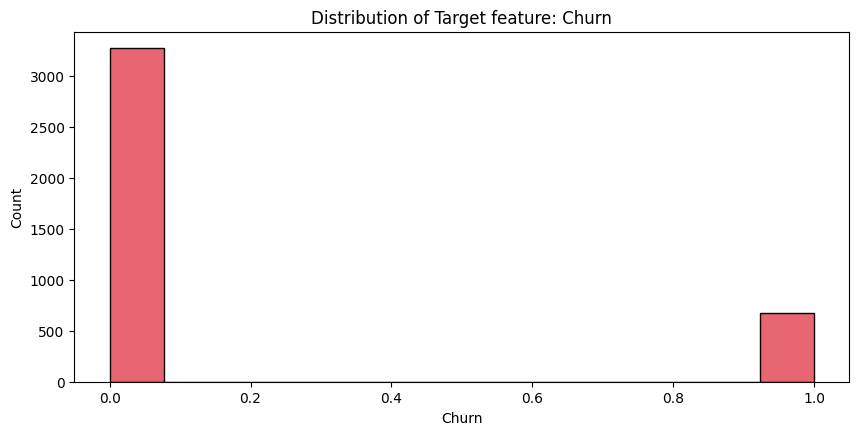

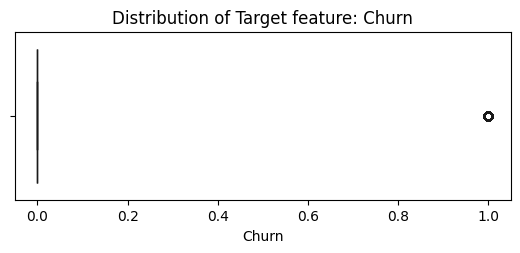

In [252]:
data_visualization.distribution_of_target_feature()

Numerical features: 

* Tenure
* WarehouseToHome
* NumberOfDeviceRegistered
* SatisfactionScore
* NumberOfAddress
* Complain
* DaySinceLastOrder
* CashbackAmount
* Churn


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating k

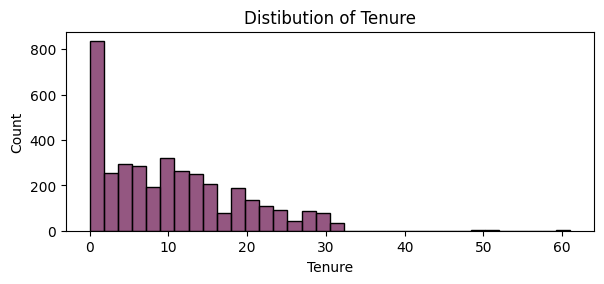

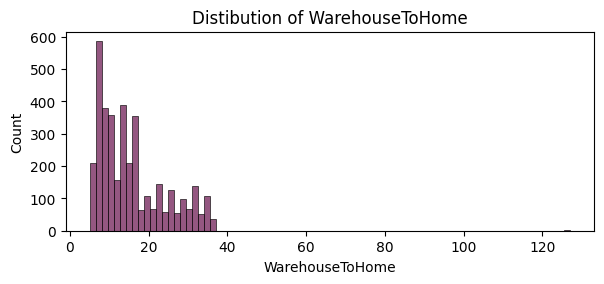

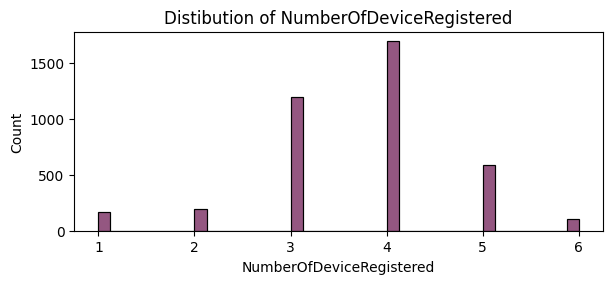

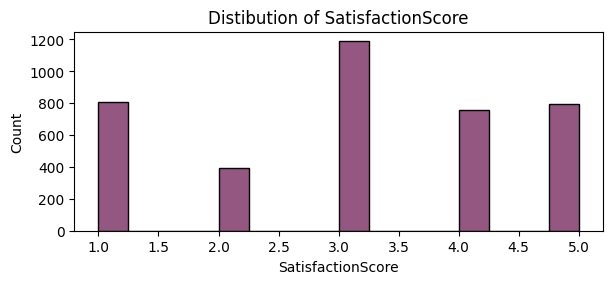

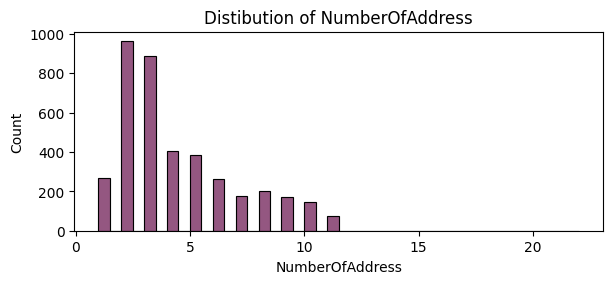

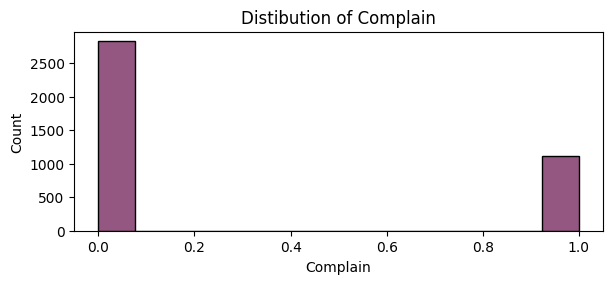

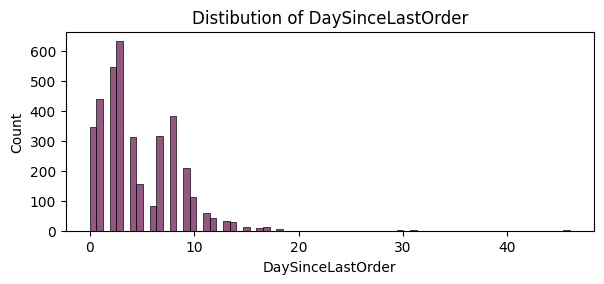

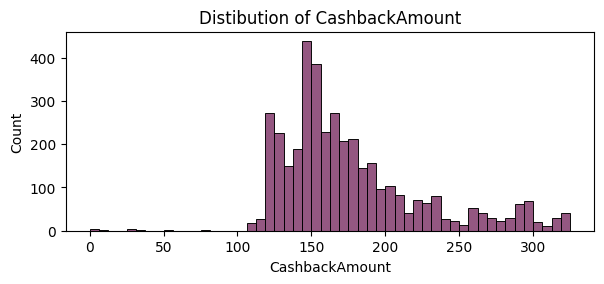

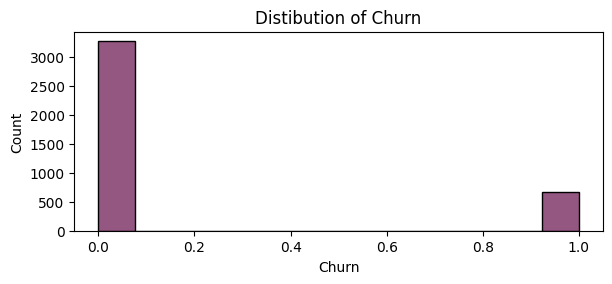

In [253]:
data_visualization.distribution_of_numerical_features()

Categorical features:

* PreferedOrderCat
* MaritalStatus
Categorical features:

* PreferedOrderCat
* MaritalStatus
Categorical features:

* PreferedOrderCat
* MaritalStatus
Categorical features:

* PreferedOrderCat
* MaritalStatus
Categorical features:

* PreferedOrderCat
* MaritalStatus


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treati

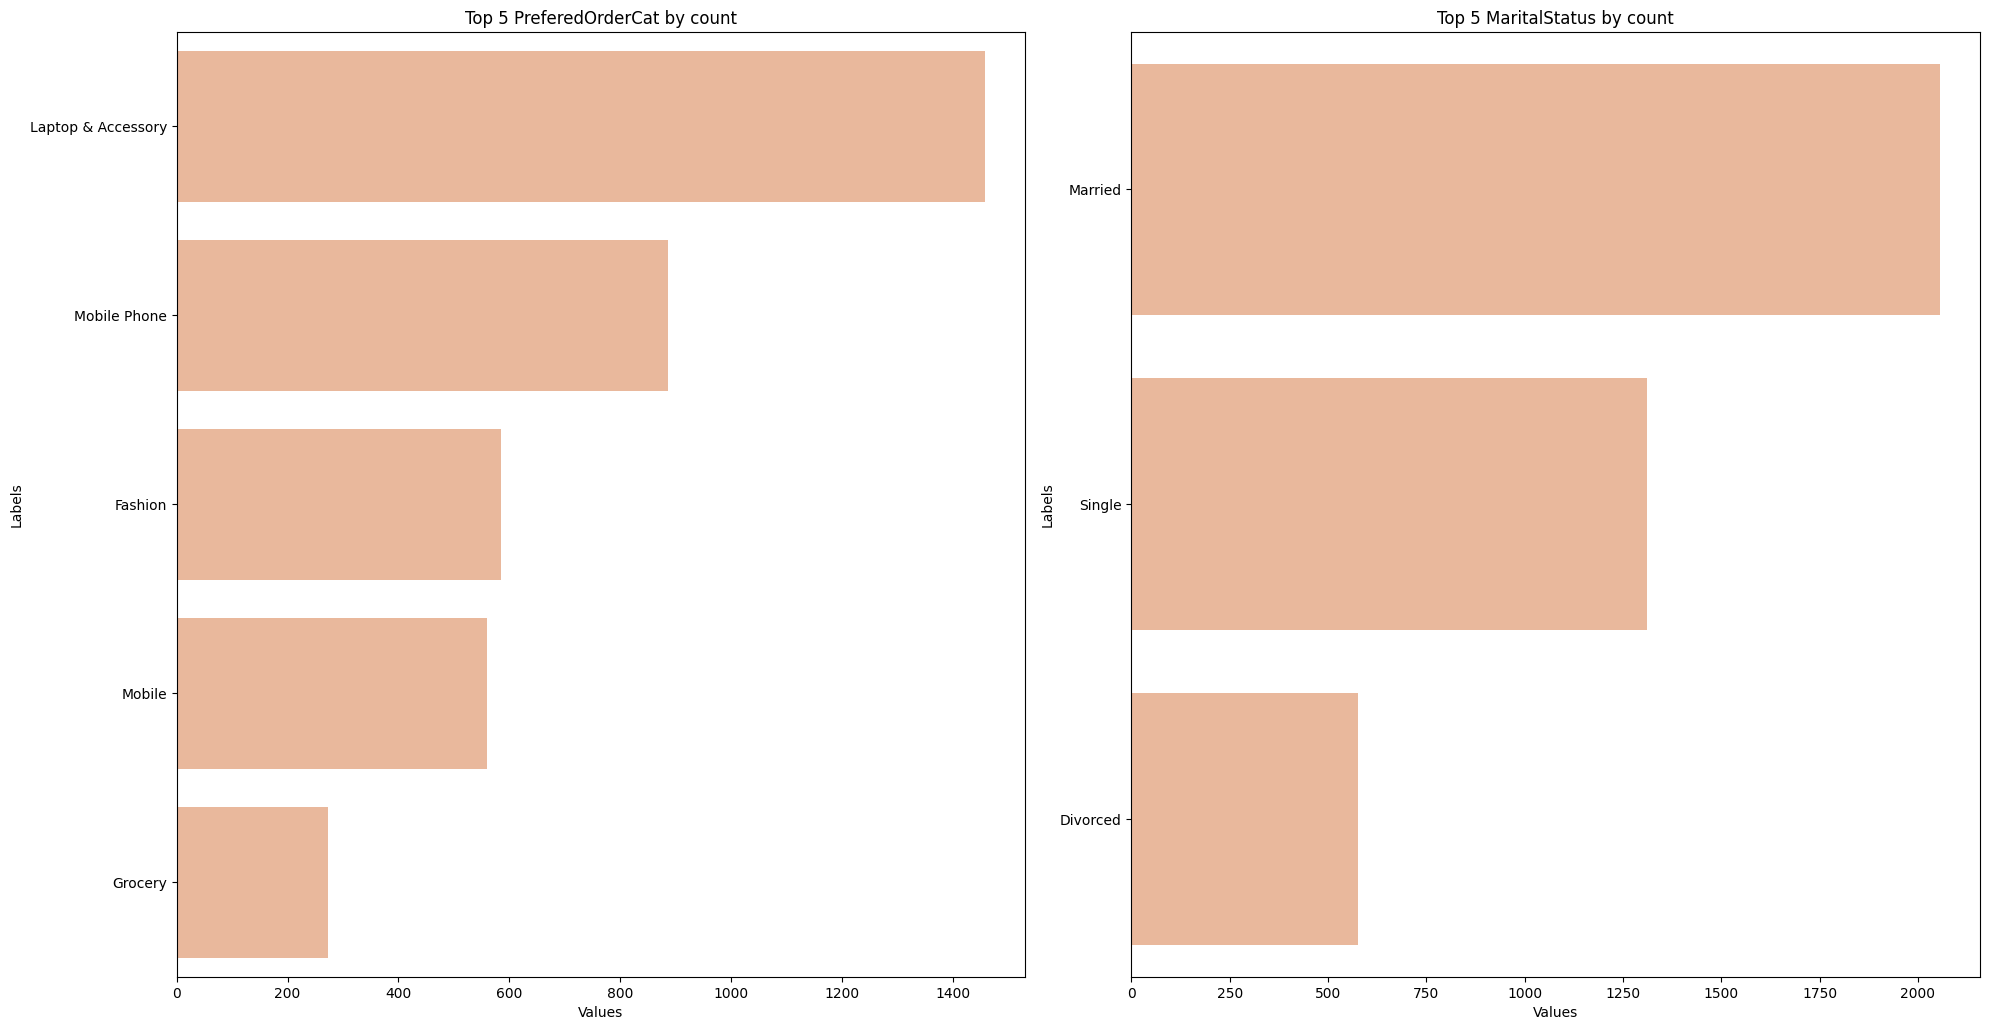

In [254]:
data_visualization.distribution_of_categorical_features()

Numerical features: 

* Tenure
* WarehouseToHome
* NumberOfDeviceRegistered
* SatisfactionScore
* NumberOfAddress
* Complain
* DaySinceLastOrder
* CashbackAmount
* Churn


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating k

<Axes: >

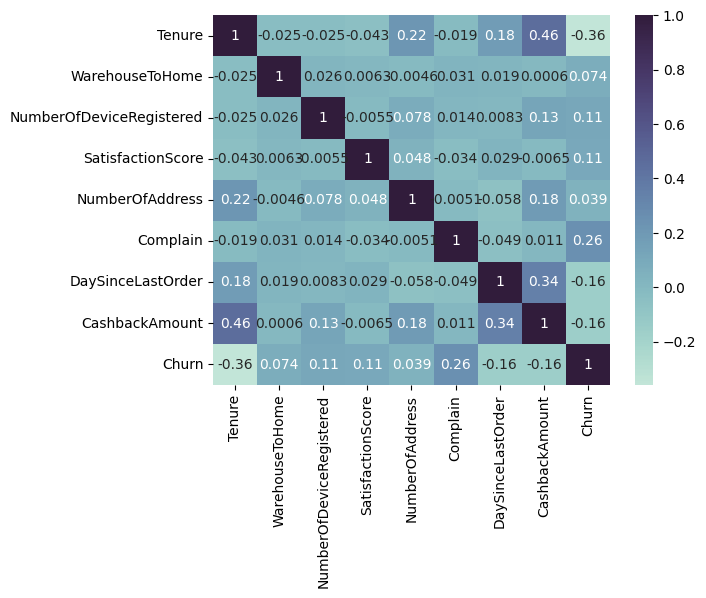

In [255]:
data_visualization.relation_numerical_feats_to_target_feat()

Categorical features:

* PreferedOrderCat
* MaritalStatus
Categorical features:

* PreferedOrderCat
* MaritalStatus
Categorical features:

* PreferedOrderCat
* MaritalStatus


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treati

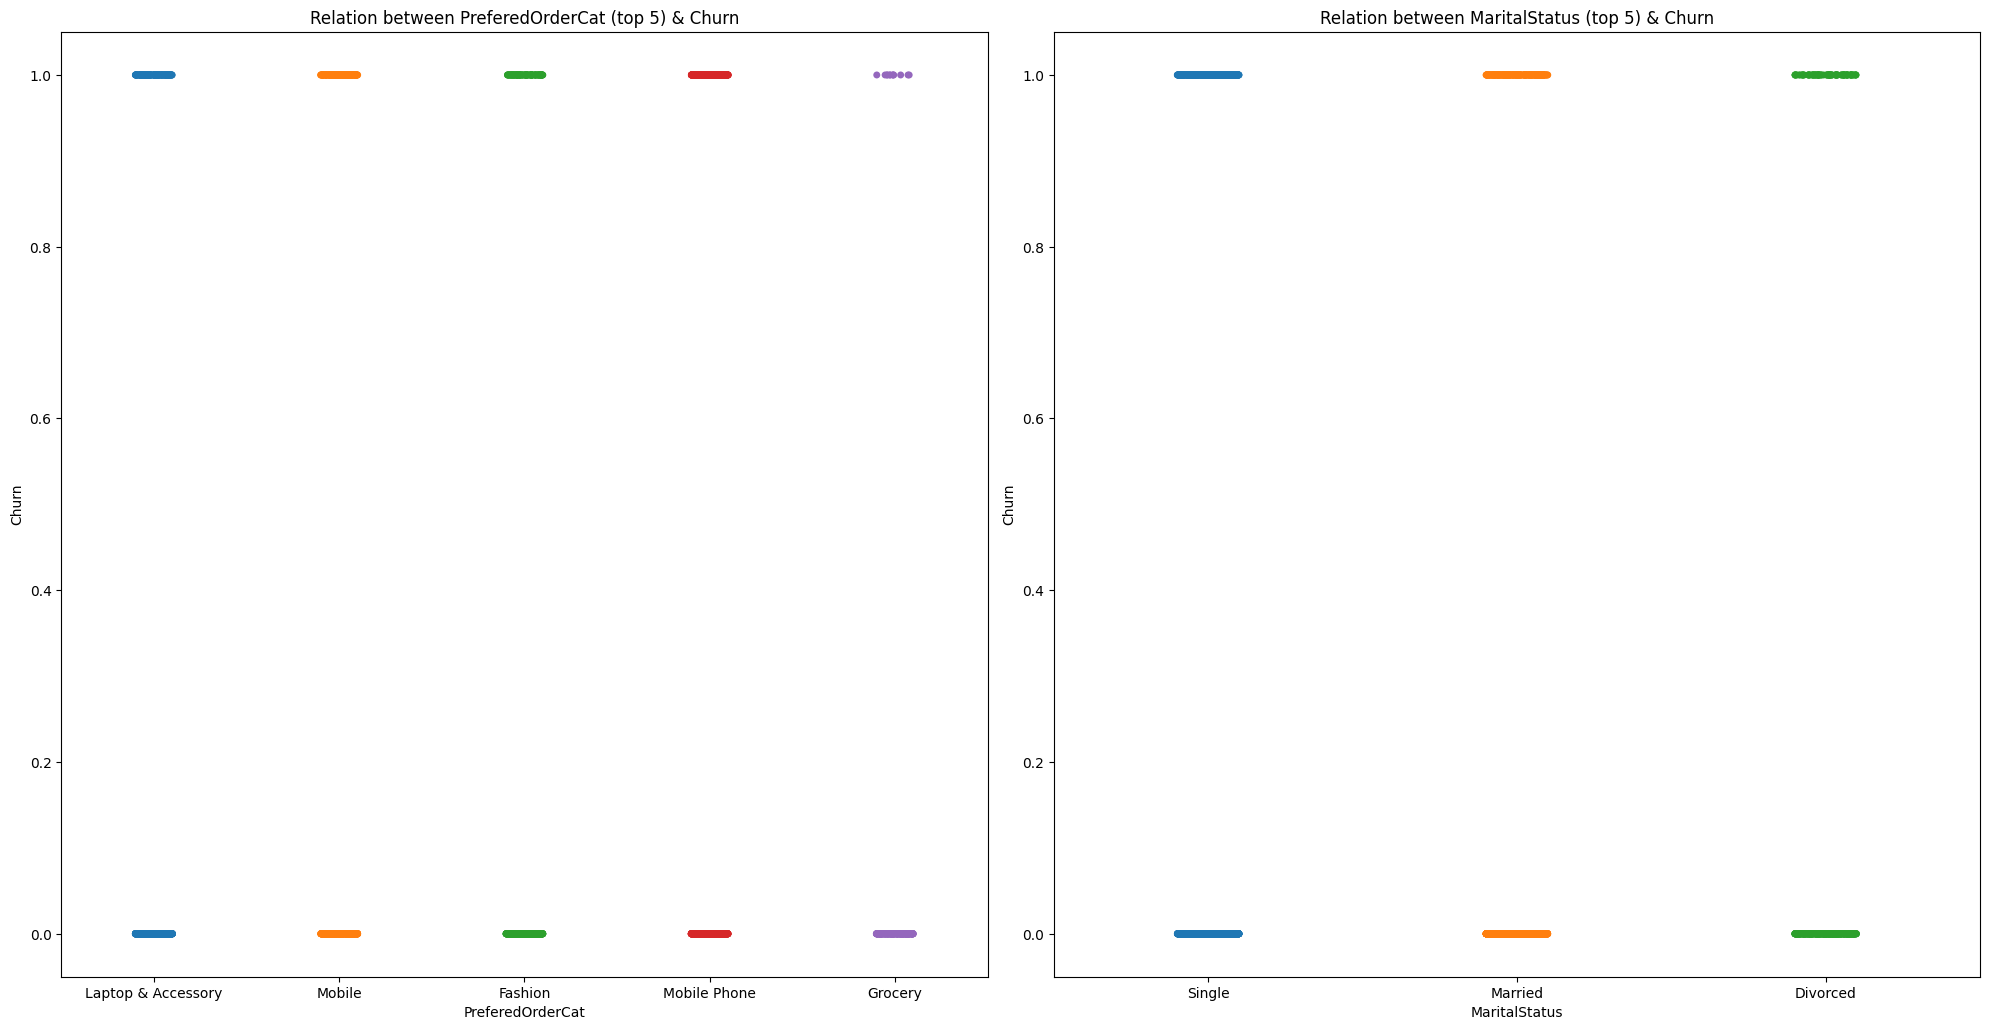

In [256]:
data_visualization.relation_categorical_feats_to_target_feat(5)

In [257]:
data_preprocessing = Data_Preprocessing(df,target_feature = target_feature)
X,y = data_preprocessing.transform()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

Numerical features: 

* Tenure
* WarehouseToHome
* NumberOfDeviceRegistered
* SatisfactionScore
* NumberOfAddress
* Complain
* DaySinceLastOrder
* CashbackAmount
* Churn
Categorical features:

* PreferedOrderCat
* MaritalStatus


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:44: FutureWarning: Series.__getitem__ treating k

((3152, 17), (3152,), (789, 17), (789,))

In [258]:
logistic_regression = LogisticRegression()
logistic_regression_params = None

naive_bayes = GaussianNB()
naive_bayes_params = None

svc = SVC()
svc_params = None

decision_tree = DecisionTreeClassifier()
decision_tree_params = [{'criterion': ['gini','entropy'], 'max_depth': [5,15,30,50,100], 'min_samples_split': [1,5,30]}]

random_forest = RandomForestClassifier()
random_forest_params = None

xgb_classifier = XGBClassifier()
xgb_classifier_params = None

base_models = [logistic_regression,naive_bayes,svc,decision_tree,random_forest,xgb_classifier]


models = [logistic_regression,naive_bayes,svc,decision_tree,random_forest,xgb_classifier]
params = [logistic_regression_params,naive_bayes_params,svc_params,decision_tree_params,random_forest_params,xgb_classifier_params]
metric = accuracy

In [259]:
voting_model = VotingClassifier(base_models)
bagging_model = Bagging_Classifier(logistic_regression,10)

voting_model.fit(X_train,y_train)
bagging_model.fit(X_train,y_train)

voting_model_prediction = voting_model.predict(X_test)
bagging_model_prediction = bagging_model.predict(X_test)

voting_model_acc = accuracy(y_test,voting_model_prediction)
bagging_model_acc = accuracy(y_test,bagging_model_prediction)


print(f'Voting model Accuracy on Test Data: {voting_model_acc}')
print(f'Bagging model Accuracy on Test Data: {bagging_model_acc}')

Voting model Accuracy on Test Data: 0.908745247148289
Bagging model Accuracy on Test Data: 0.8276299112801014


In [260]:
Optimal = Optimal_model(models,metric,X_train,y_train,X_test,y_test,params = params)

Optimal.fit()
optimal_model = Optimal.optimal()


Model: LogisticRegression()
Trainer: <__main__.Train_model object at 0x134a5a550>
Model: LogisticRegression()
X for train n_samples: 3152
X for train n_features: 17

<function accuracy_score at 0x13159dee0> on Train Data: 0.833756345177665
<function accuracy_score at 0x13159dee0> on Test Data: 0.8326996197718631



Model: GaussianNB()
Trainer: <__main__.Train_model object at 0x133705610>
Model: GaussianNB()
X for train n_samples: 3152
X for train n_features: 17

<function accuracy_score at 0x13159dee0> on Train Data: 0.6963832487309645
<function accuracy_score at 0x13159dee0> on Test Data: 0.6894803548795945



Model: SVC()
Trainer: <__main__.Train_model object at 0x1336bc510>
Model: SVC()
X for train n_samples: 3152
X for train n_features: 17

<function accuracy_score at 0x13159dee0> on Train Data: 0.8270939086294417
<function accuracy_score at 0x13159dee0> on Test Data: 0.8365019011406845



Model: DecisionTreeClassifier()
Trainer: <__main__.Train_model object at 0x1366cc310>
Model:

In [261]:
data = df[[column for column in df.columns if column != target_feature]]

prediction = Predict(data,optimal_model)
print(f'Prediction: {prediction} | prediction first 5 elements: {prediction[:5]}\n\n\n')

Categorical features:

* PreferedOrderCat
* MaritalStatus
Prediction: [0 0 0 ... 0 1 0] | prediction first 5 elements: [0 0 0 0 0]





/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_8843/4263177674.py:33: FutureWarning: Series.__getitem__ treati